In [ ]:
pip install segmentation_model_3D

In [ ]:
pip install splitfolders

In [24]:
import tensorflow 
print(tensorflow.__version__)

2.16.1


In [3]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import random

In [4]:
scaler = MinMaxScaler()
TRAIN_DATASET_PATH = "C:/Users/simon/Desktop/Universita/Tirocinio/brats2023/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"


#test per vedere se ha caricato tutto
test_image_flair = nib.load('C:/Users/simon/Desktop/Universita/Tirocinio/brats2023/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz').get_fdata()

print(test_image_flair.shape)
print(test_image_flair.max())

(240, 240, 155)
2934.0


## Lavorazione dei dati

In [73]:


t2_list = sorted(glob.glob(TRAIN_DATASET_PATH + "/*/*t2w.nii.gz"))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH + "/*/*t1c.nii.gz"))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH + "/*/*t2f.nii.gz"))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH + "/*/*seg.nii.gz"))


print(len(t2_list))

1251


In [88]:
for img in range(len(t2_list)):
  print('Now preparing image and mask number: ', img)

  temp_image_t2 = nib.load(t2_list[img]).get_fdata()
  temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

  temp_image_flair = nib.load(flair_list[img]).get_fdata()
  temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

  temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
  temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

  temp_mask = nib.load(mask_list[img]).get_fdata()
  temp_mask = temp_mask.astype(np.uint8)

  temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis = 3)

  val, counts = np.unique(temp_mask, return_counts=True)

  if (1 - (counts[0]/counts.sum())) > 0.01:
    print('Save me')
    temp_mask = to_categorical(temp_mask, num_classes=4)
    #np.save('/content/input3dChannel/images/image_'+str(img)+'.npy', temp_combined_images)
    #np.save('/content/input3dChannel/masks/mask_'+str(img)+'.npy', temp_mask)
    print(temp_combined_images.shape, temp_mask.shape)
    np.save("C:/Users/simon/Desktop/Universita/Tirocinio/prova240/input3channel/images/image_" + str(img)+'.npy', temp_combined_images)
    np.save("C:/Users/simon/Desktop/Universita/Tirocinio/prova240/input3channel/masks/mask_" + str(img)+'.npy', temp_mask)
    
  else:
    print('Skip me')

Now preparing image and mask number:  0
Skip me
Now preparing image and mask number:  1
Save me
(240, 240, 155, 3) (240, 240, 155, 4)
(240, 240, 160, 3) (240, 240, 160, 4)
Now preparing image and mask number:  2
Save me
(240, 240, 155, 3) (240, 240, 155, 4)
(240, 240, 160, 3) (240, 240, 160, 4)
Now preparing image and mask number:  3
Save me
(240, 240, 155, 3) (240, 240, 155, 4)
(240, 240, 160, 3) (240, 240, 160, 4)


In [ ]:
import splitfolders

input_folder = 'brats23-TrainingData\\input3Channel'
output_folder = 'brats23-TrainingData\\input_data_128'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .20), group_prefix=None)

## Codice per il modello

In [3]:
import os


def load_img(img_dir, img_list):
  images = []
  for i, img_name in enumerate(img_list):
    if (img_name.split('.')[-1] == 'npy'):
      image = np.load(img_dir+ '/' +img_name)

      images.append(image)

  images = np.array(images)
  return(images)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

  L = len(img_list)

  while True:

    batch_start = 0
    batch_end = batch_size

    while batch_start < L:
      limit = min(batch_end, L)
      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])

      yield X, Y

      batch_start += batch_size
      batch_end += batch_size


In [4]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(240, 240, 144, 3, 4)
print(model.input_shape)
print(model.output_shape)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 160, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 240, 240,  │      1,312 │ input_layer[0][0] │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 240, 240,  │          0 │ conv3d[0][0]      │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 240, 240,  │      6,928 │ dropout[0][0]     │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 120, 120,  │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 80, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 120, 120,  │     13,856 │ max_pooling3d[0]… │
│                     │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 120, 120,  │          0 │ conv3d_2[0][0]    │
│                     │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 120, 120,  │     27,680 │ dropout_1[0][0]   │
│                     │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 60, 60,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 60, 60,    │     55,360 │ max_pooling3d_1[… │
│                     │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 60,    │          0 │ conv3d_4[0][0]    │
│                     │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 60, 60,    │    110,656 │ dropout_2[0][0]   │
│                     │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 30, 30,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 20, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 30, 30,    │    221,312 │ max_pooling3d_2[… │
│                     │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30, 30,    │          0 │ conv3d_6[0][0]    │
│                     │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 30, 30,    │    442,496 │ dropout_3[0][0]   │
│                     │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 15, 15,    │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 240, 240, 160, 3)
(None, 240, 240, 160, 4)


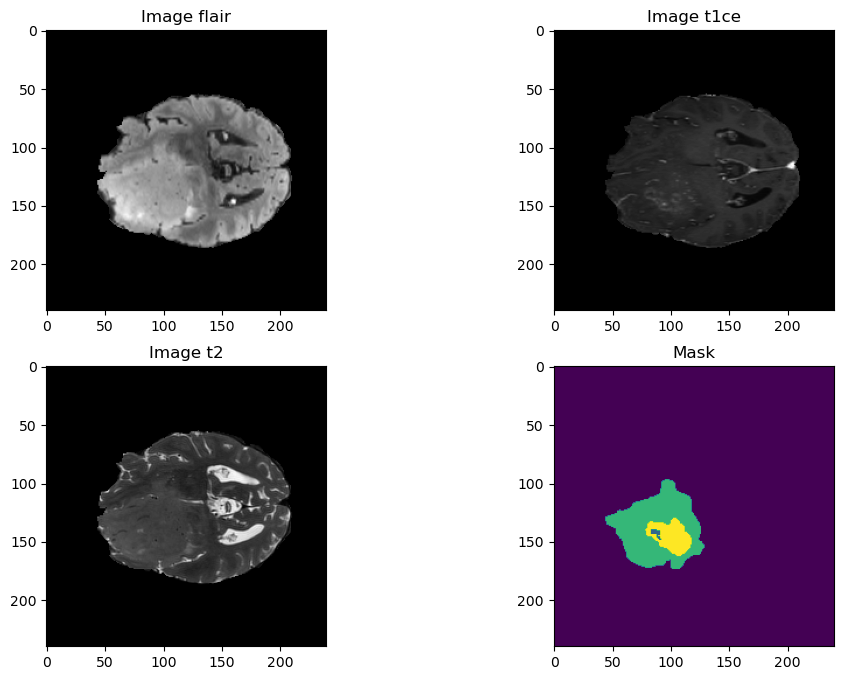

In [76]:
train_img_dir = "C:/Users/simon/Desktop/Universita/Tirocinio/prova240/input_data_128/train/images"
train_mask_dir = "C:/Users/simon/Desktop/Universita/Tirocinio/prova240/input_data_128/train/masks"

val_img_dir = "C:/Users/simon/Desktop/Universita/Tirocinio/prova240/input_data_128/val/images"
val_mask_dir = "C:/Users/simon/Desktop/Universita/Tirocinio/prova240/input_data_128/val/masks"


train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))


val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))


batch_size = 16

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)



In [77]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

import segmentation_models_3D as sm
import keras

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [78]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


# from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=240,
                          IMG_WIDTH=240,
                          IMG_DEPTH=160,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=3,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 160, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_76 (Conv3D)  │ (None, 240, 240,  │      1,312 │ input_layer_4[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 240, 240,  │          0 │ conv3d_76[0][0]   │
│ (Dropout)           │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_77 (Conv3D)  │ (None, 240, 240,  │      6,928 │ dropout_36[0][0]  │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_16    │ (None, 120, 120,  │          0 │ conv3d_77[0][0]   │
│ (MaxPooling3D)      │ 80, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_78 (Conv3D)  │ (None, 120, 120,  │     13,856 │ max_pooling3d_16… │
│                     │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 120, 120,  │          0 │ conv3d_78[0][0]   │
│ (Dropout)           │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_79 (Conv3D)  │ (None, 120, 120,  │     27,680 │ dropout_37[0][0]  │
│                     │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_17    │ (None, 60, 60,    │          0 │ conv3d_79[0][0]   │
│ (MaxPooling3D)      │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_80 (Conv3D)  │ (None, 60, 60,    │     55,360 │ max_pooling3d_17… │
│                     │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 60, 60,    │          0 │ conv3d_80[0][0]   │
│ (Dropout)           │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_81 (Conv3D)  │ (None, 60, 60,    │    110,656 │ dropout_38[0][0]  │
│                     │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_18    │ (None, 30, 30,    │          0 │ conv3d_81[0][0]   │
│ (MaxPooling3D)      │ 20, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_82 (Conv3D)  │ (None, 30, 30,    │    221,312 │ max_pooling3d_18… │
│                     │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 30, 30,    │          0 │ conv3d_82[0][0]   │
│ (Dropout)           │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_83 (Conv3D)  │ (None, 30, 30,    │    442,496 │ dropout_39[0][0]  │
│                     │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_19    │ (None, 15, 15,    │          0 │ conv3d_83[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 160, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_76 (Conv3D)  │ (None, 240, 240,  │      1,312 │ input_layer_4[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 240, 240,  │          0 │ conv3d_76[0][0]   │
│ (Dropout)           │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_77 (Conv3D)  │ (None, 240, 240,  │      6,928 │ dropout_36[0][0]  │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_16    │ (None, 120, 120,  │          0 │ conv3d_77[0][0]   │
│ (MaxPooling3D)      │ 80, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_78 (Conv3D)  │ (None, 120, 120,  │     13,856 │ max_pooling3d_16… │
│                     │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 120, 120,  │          0 │ conv3d_78[0][0]   │
│ (Dropout)           │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_79 (Conv3D)  │ (None, 120, 120,  │     27,680 │ dropout_37[0][0]  │
│                     │ 80, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_17    │ (None, 60, 60,    │          0 │ conv3d_79[0][0]   │
│ (MaxPooling3D)      │ 40, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_80 (Conv3D)  │ (None, 60, 60,    │     55,360 │ max_pooling3d_17… │
│                     │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 60, 60,    │          0 │ conv3d_80[0][0]   │
│ (Dropout)           │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_81 (Conv3D)  │ (None, 60, 60,    │    110,656 │ dropout_38[0][0]  │
│                     │ 40, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_18    │ (None, 30, 30,    │          0 │ conv3d_81[0][0]   │
│ (MaxPooling3D)      │ 20, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_82 (Conv3D)  │ (None, 30, 30,    │    221,312 │ max_pooling3d_18… │
│                     │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 30, 30,    │          0 │ conv3d_82[0][0]   │
│ (Dropout)           │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_83 (Conv3D)  │ (None, 30, 30,    │    442,496 │ dropout_39[0][0]  │
│                     │ 20, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_19    │ (None, 15, 15,    │          0 │ conv3d_83[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 240, 240, 160, 3)
(None, 240, 240, 160, 4)
Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.5544 - iou_score: 2.5057e-05 - loss: 1.0185 - val_accuracy: 0.7724 - val_iou_score: 4.4690e-06 - val_loss: 1.0157
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 209s 209s/step - accuracy: 0.6808 - iou_score: 1.0187e-04 - loss: 1.0147 - val_accuracy: 0.8443 - val_iou_score: 2.2993e-05 - val_loss: 1.0176
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 59s 59s/step - accuracy: 0.7580 - iou_score: 3.7251e-04 - loss: 1.0165 - val_accuracy: 0.8409 - val_iou_score: 9.4357e-05 - val_loss: 1.0131


In [79]:
model.save("C:/Users/simon/Desktop/Universita/Tirocinio/prova240/tf_model.keras")

In [80]:
import tensorflow as tf
import segmentation_models_3D as sm
import numpy as np
import keras

# Definisci i pesi delle classi per DiceLoss
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Funzione wrapper per la perdita combinata
def dice_loss_plus_1focal_loss():
    return dice_loss + (1 * focal_loss)

# Funzione per ricostruire SumOfLosses
def sum_of_losses_from_config(config):
    return dice_loss_plus_1focal_loss()

# Funzione per ricostruire IOUScore
def iou_score_from_config(config):
    return sm.metrics.IOUScore(threshold=0.5)

# Mappa dei tuoi oggetti personalizzati
custom_objects = {
    'DiceLoss': sm.losses.DiceLoss,
    'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss,
    'SumOfLosses': sum_of_losses_from_config,  # Simula il metodo from_config
    'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss,
    'IOUScore': iou_score_from_config,  # Simula il metodo from_config
    'Adam': keras.optimizers.Adam,
}

# Carica il modello salvato
model = tf.keras.models.load_model(
    "C:/Users/simon/Desktop/Universita/Tirocinio/prova240/tf_model.keras",
    custom_objects=custom_objects
)

In [91]:
#for img in range(len(t2_list)):
def pad_image(image, target_shape):
    # Assicurati che target_shape abbia lo stesso numero di dimensioni di image.shape
    assert len(image.shape) == len(target_shape), "target_shape deve avere lo stesso numero di dimensioni di image.shape"
    
    # Calcola il padding necessario per ciascun asse
    pad_width = [(0, 0) for _ in range(len(image.shape))]
    pad_width[2] = (0, target_shape[2] - image.shape[2])  # Padding sull'asse z
    return np.pad(image, pad_width, mode='constant', constant_values=0)

def remove_padding(image, original_shape):
    slices = tuple(slice(0, original_shape[i]) for i in range(len(original_shape)))
    return image[slices]

target_shape = (240, 240, 160, 3)

scaler = MinMaxScaler()

dir = "C:/Users/simon/Desktop/Universita/Tirocinio/brats2023/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000"
t2 = glob.glob(dir + "/*t2w.nii.gz")
t1ce = glob.glob(dir + "/*t1c.nii.gz")
flair = glob.glob(dir + "/*t2f.nii.gz")
mask = glob.glob(dir + "/*seg.nii.gz")

print(t2, t1ce, flair)

print('Preparing image and mask number')

temp_image_t2 = nib.load(t2[0]).get_fdata()
temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

temp_image_flair = nib.load(flair[0]).get_fdata()
temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

temp_image_t1c = nib.load(t1ce[0]).get_fdata()
temp_image_t1c = scaler.fit_transform(temp_image_t1c.reshape(-1, temp_image_t1c.shape[-1])).reshape(temp_image_t1c.shape)

temp_mask = nib.load(mask[0]).get_fdata()
temp_mask = temp_mask.astype(np.uint8)

temp_combined_images = np.stack([temp_image_flair, temp_image_t1c, temp_image_t2], axis = 3)


val, counts = np.unique(temp_mask, return_counts=True)

temp_mask = to_categorical(temp_mask, num_classes=4)

padded_img = pad_image(temp_combined_images, target_shape)
padded_mask = pad_image(temp_mask, target_shape)
np.save("C:/Users/simon/Desktop/Universita/Tirocinio/prova240/result/image.npy", padded_img)
np.save("C:/Users/simon/Desktop/Universita/Tirocinio/prova240/result/mask.npy", padded_mask)


['C:/Users/simon/Desktop/Universita/Tirocinio/brats2023/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000\\BraTS-GLI-00000-000-t2w.nii.gz'] ['C:/Users/simon/Desktop/Universita/Tirocinio/brats2023/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000\\BraTS-GLI-00000-000-t1c.nii.gz'] ['C:/Users/simon/Desktop/Universita/Tirocinio/brats2023/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000\\BraTS-GLI-00000-000-t2f.nii.gz']
Preparing image and mask number
(240, 240, 155, 3)
(240, 240, 155)


In [97]:

test_img = np.load("C:/Users/simon/Desktop/Universita/Tirocinio/prova240/result/image.npy")

test_mask = np.load("C:/Users/simon/Desktop/Universita/Tirocinio/prova240/result/mask.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

def remove_padding(image, original_shape):
    slices = tuple(slice(0, original_shape[i]) for i in range(len(original_shape)))
    return image[slices]

test = remove_padding(test_prediction_argmax, (240, 240, 155))



np.save('C:/Users/simon/Desktop/Universita/Tirocinio/prova240/result/prediction.npy', test_prediction_argmax)




1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [99]:
print(test.shape)

(240, 240, 155)


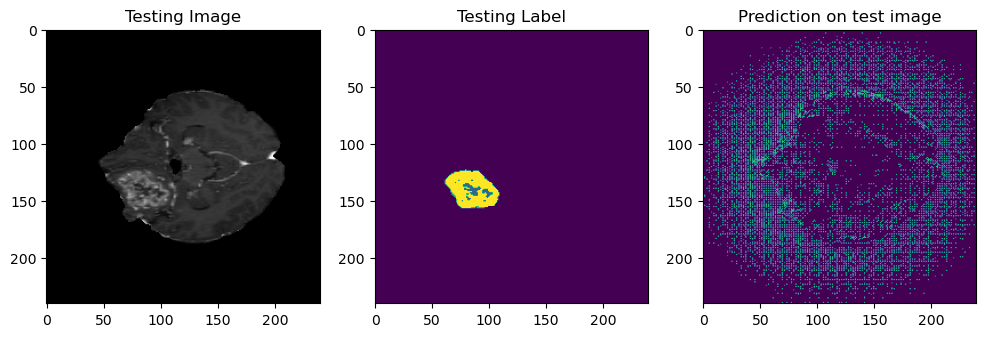

In [100]:
from matplotlib import pyplot as plt
import random


#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 57
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test[:,:, n_slice])

## IGNORARE

In [ ]:
train_img_dir = "Little_brats2023\\input_data_128\\train\\images"
train_mask_dir = "Little_brats2023\\input_data_128\\train\\masks"

val_img_dir = "Little_brats2023\\input_data_128\\val\\images"
val_mask_dir = "Little_brats2023\\input_data_128\\val\\masks"

train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

batch_size = 16

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)


img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


# from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

## Post Training

In [5]:
import tensorflow as tf
import segmentation_models_3D as sm
import numpy as np
import keras

# Definisci i pesi delle classi per DiceLoss
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Funzione wrapper per la perdita combinata
def dice_loss_plus_1focal_loss():
    return dice_loss + (1 * focal_loss)

# Funzione per ricostruire SumOfLosses
def sum_of_losses_from_config(config):
    return dice_loss_plus_1focal_loss()

# Funzione per ricostruire IOUScore
def iou_score_from_config(config):
    return sm.metrics.IOUScore(threshold=0.5)

# Mappa dei tuoi oggetti personalizzati
custom_objects = {
    'DiceLoss': sm.losses.DiceLoss,
    'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss,
    'SumOfLosses': sum_of_losses_from_config,  # Simula il metodo from_config
    'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss,
    'IOUScore': iou_score_from_config,  # Simula il metodo from_config
    'Adam': keras.optimizers.Adam,
}

# Carica il modello salvato
model = tf.keras.models.load_model(
    "pesi.keras",
    custom_objects=custom_objects
)

In [6]:

scaler = MinMaxScaler()

dir = "C:\\Users\\simon\\Desktop\\Universita\\Tirocinio\\brats2023\\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\\BraTS-GLI-00000-000"
t2 = glob.glob(dir + "\*t2w.nii.gz")
t1ce = glob.glob(dir + "\*t1c.nii.gz")
flair = glob.glob(dir + "\*t2f.nii.gz")
mask = glob.glob(dir + "\*seg.nii.gz")

In [7]:
#for img in range(len(t2_list)):
def pad_image(image, target_shape):
    # Assicurati che target_shape abbia lo stesso numero di dimensioni di image.shape
    assert len(image.shape) == len(target_shape), "target_shape deve avere lo stesso numero di dimensioni di image.shape"
    
    # Calcola il padding necessario per ciascun asse
    pad_width = [(0, 0) for _ in range(len(image.shape))]
    pad_width[2] = (0, target_shape[2] - image.shape[2])  # Padding sull'asse z
    return np.pad(image, pad_width, mode='constant', constant_values=0)

def remove_padding(image, original_shape):
    slices = tuple(slice(0, original_shape[i]) for i in range(len(original_shape)))
    return image[slices]

print('Preparing image and mask number')

temp_image_t2 = nib.load(t2[0]).get_fdata()
print(temp_image_t2.shape)
temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
print(temp_image_t2.shape)

temp_image_flair = nib.load(flair[0]).get_fdata()
temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

temp_image_t1c = nib.load(t1ce[0]).get_fdata()
temp_image_t1c = scaler.fit_transform(temp_image_t1c.reshape(-1, temp_image_t1c.shape[-1])).reshape(temp_image_t1c.shape)

temp_mask = nib.load(mask[0]).get_fdata()
temp_mask = temp_mask.astype(np.uint8)

temp_combined_images = np.stack([temp_image_flair, temp_image_t1c, temp_image_t2], axis = 3)

#crop to a size divisible by 64 to work later with patches by 64x64x64

#temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
#temp_mask = temp_mask[56:184, 56:184, 13:141]

val, counts = np.unique(temp_mask, return_counts=True)

temp_mask = to_categorical(temp_mask, num_classes=4)

target_shape = (240, 240, 160, 3)

padded_img = pad_image(temp_combined_images, target_shape)
padded_mask = pad_image(temp_mask, target_shape)

print(padded_img.shape, padded_mask.shape)

np.save('results/image.npy', padded_img)
np.save('results/mask.npy', padded_mask)

Preparing image and mask number
(240, 240, 155)
(240, 240, 155)
(240, 240, 160, 3) (240, 240, 160, 4)


In [8]:
test_img = np.load("results\image.npy")

print(test_img.shape)

test_mask = np.load("results\mask.npy")

test_mask_argmax=np.argmax(test_mask, axis=3)

print(test_mask_argmax.shape)

test_img_input = np.expand_dims(test_img, axis=0)
print(test_img_input.shape)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

print(test_prediction_argmax.shape)

#test_img = remove_padding(test_prediction_argmax, (240, 240, 155, 3))

np.save('results/prediction.npy', test_prediction_argmax)


(240, 240, 160, 3)
(240, 240, 160)
(1, 240, 240, 160, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 69s 69s/step
(240, 240, 160)


(240, 240, 155)
(240, 240, 155)


(240, 240, 160)


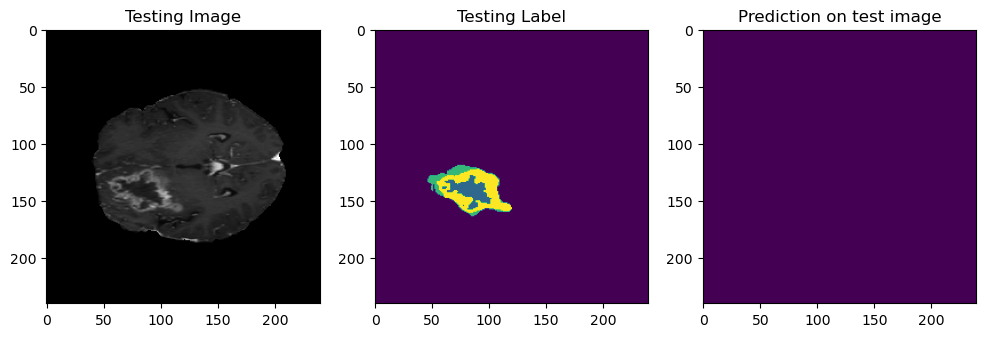

In [16]:
from matplotlib import pyplot as plt
import random

pred = np.load('results/prediction.npy')
print(pred.shape)

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 70
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(pred[:,:, n_slice])

In [17]:
print(pred.shape)

(240, 240, 160)


In [19]:
print(test_mask_argmax.shape)

(240, 240, 160)
